In [65]:
#needs a kernel that can load matplotlib, pandas, numpy (does not need to be a microsim kernel)

In [66]:
import os
import matplotlib.pyplot as plt
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('max_colwidth', None)
#pd.set_option('max_rows', None)
#pd.set_option('max_columns', None)
pd.set_option('display.max_rows', None)
pd.options.display.float_format = '{:,.4f}'.format
import numpy as np

In [67]:
resultsDir = "/users/PAS2164/deligkaris/MICROSIM/SIMULATIONS/PRELIMINARY-TRIALS-100-CV-ALL-DEMENTIA-ALL"
os.chdir(resultsDir)
data=pd.read_csv("inputLog.csv")

In [68]:
#some regression results are nan
data.head() 

,reg,se,pvalue,duration,sampleSize,outcome,analysis,dementiaRisk,cvRisk
0,-28.6097,"1,130,140.1029",1.0000,3,100,death,logisticRegression-death,0.0000,0.0000
1,NaN,NaN,NaN,3,100,death,logisticRegression-death,0.0000,0.0000
2,NaN,NaN,NaN,3,100,death,logisticRegression-death,0.0000,0.0000
3,NaN,NaN,NaN,3,100,death,logisticRegression-death,0.0000,0.0000
4,NaN,NaN,NaN,3,100,death,logisticRegression-death,0.0000,0.0000


In [69]:
data.shape

(600000, 9)

In [70]:
#how many regressions returned nan in absolute number and percent wise 
data["reg"].isna().sum(),data["reg"].isna().sum()/data.shape[0]

(13764, 0.02294)

In [71]:
# nans tend to be small sample sizes (but not always), results from logistic regression 
data[data["reg"].isna()].sample(20)

,reg,se,pvalue,duration,sampleSize,outcome,analysis,dementiaRisk,cvRisk
121241,NaN,NaN,NaN,15,100,death,logisticRegression-death,0.0002,0.0000
84463,NaN,NaN,NaN,5,200,death,logisticRegression-death,0.0000,0.0061
194311,NaN,NaN,NaN,3,15000,deathstroke-mi-dementia-,logisticRegression-deathstroke-mi-dementia-,0.0002,0.0061
360840,NaN,NaN,NaN,10,100,death,logisticRegression-death,0.0059,0.0000
337642,NaN,NaN,NaN,20,100,death,logisticRegression-death,0.0013,0.0132
197837,NaN,NaN,NaN,20,5000,deathstroke-mi-,logisticRegression-deathstroke-mi-,0.0002,0.0061
256440,NaN,NaN,NaN,5,100,deathstroke-mi-,logisticRegression-deathstroke-mi-,0.0013,0.0000
256085,NaN,NaN,NaN,3,200,deathstroke-mi-,logisticRegression-deathstroke-mi-,0.0013,0.0000
555786,NaN,NaN,NaN,20,1000,deathstroke-mi-dementia-,logisticRegression-deathstroke-mi-dementia-,0.0257,0.0061
121677,NaN,NaN,NaN,20,200,death,logisticRegression-death,0.0002,0.0000


In [72]:
#if the result is nan, most likely it is a small sample size
#but from one 20,000 sample trial I get 200 100 sample trials and 5354/598 is a factor of ~10 so smaller 
#sample trials less likely (by a factor of ~20) to return nan in regression
data[data["reg"].isna()]["sampleSize"].value_counts()

100      5354
200      3292
500      1623
1000     1051
5000      630
10000     614
15000     602
20000     598
Name: sampleSize, dtype: int64

In [73]:
data[data["reg"].isna()]["outcome"].value_counts()

deathstroke-mi-dementia-    5520
deathstroke-mi-             4716
death                       3528
Name: outcome, dtype: int64

In [74]:
#linear regression did not result in nan
data[data["reg"].isna()]["analysis"].value_counts()

logisticRegression-deathstroke-mi-dementia-    5520
logisticRegression-deathstroke-mi-             4716
logisticRegression-death                       3528
Name: analysis, dtype: int64

In [75]:
data[data["reg"].isna()]["dementiaRisk"].value_counts()

0.0002    6103
0.0257    2350
0.0059    1956
0.0000    1745
0.0013    1610
Name: dementiaRisk, dtype: int64

In [76]:
data[data["reg"].isna()]["cvRisk"].value_counts()

0.0061    5165
0.0000    4810
0.0132    2337
0.0008    1058
0.0026     394
Name: cvRisk, dtype: int64

In [77]:
#if count() is doing what I think is doing, then small and large cv risks are more likely to return nan 
#in logistic regression
#note the massive 4015 for dementia risk 0.0002 and 0.0061

data[data["reg"].isna()].groupby(["dementiaRisk","cvRisk"]).count()

reg  se  pvalue  duration  sampleSize  outcome  analysis
dementiaRisk cvRisk                                                          
0.0000       0.0000    0   0       0       682         682      682       682
             0.0008    0   0       0       354         354      354       354
             0.0026    0   0       0        61          61       61        61
             0.0061    0   0       0       312         312      312       312
             0.0132    0   0       0       336         336      336       336
0.0002       0.0000    0   0       0      1455        1455     1455      1455
             0.0008    0   0       0       200         200      200       200
             0.0026    0   0       0        92          92       92        92
             0.0061    0   0       0      4015        4015     4015      4015
             0.0132    0   0       0       341         341      341       341
0.0013       0.0000    0   0       0      1095        1095     1095      1095
             0.0008    0   0       0        57          57       57        57
             0.0026    0   0       0       122         122      122       122
             0.0061    0   0       0         4           4        4         4
             0.0132    0   0       0       332         332      332       332
0.0059       0.0000    0   0       0       934         934      934       934
             0.0008    0   0       0       236         236      236       236
             0.0026    0   0       0        47          47       47        47
             0.0061    0   0       0       213         213      213       213
             0.0132    0   0       0       526         526      526       526
0.0257       0.0000    0   0       0       644         644      644       644
             0.0008    0   0       0       211         211      211       211
             0.0026    0   0       0        72          72       72        72
             0.0061    0   0       0       621         621      621       621
             0.0132    0   0       0       802         802      802       802

In [78]:
#from now on keep rows without nan
results = data.dropna(axis=0).copy()

In [79]:
results.sample(10)

,reg,se,pvalue,duration,sampleSize,outcome,analysis,dementiaRisk,cvRisk
475629,-0.8600,0.6804,0.2093,20,100,_qalys-sum,linearRegression-_qalys-sum,0.0059,0.0132
247088,-0.0066,0.0230,0.7739,10,10000,_qalys-sum,linearRegression-_qalys-sum,0.0013,0.0000
104846,-0.0400,0.3924,0.9190,10,100,_gcp-mean,linearRegression-_gcp-mean,0.0000,0.0132
269529,-0.0507,0.0327,0.1206,15,15000,deathstroke-mi-,logisticRegression-deathstroke-mi-,0.0013,0.0008
214991,0.8800,0.4713,0.0622,10,1000,_gcp-last,linearRegression-_gcp-last,0.0002,0.0061
403325,0.0280,0.2714,0.9179,15,500,_qalys-sum,linearRegression-_qalys-sum,0.0059,0.0008
513627,-0.5400,0.5770,0.3516,20,100,_gcp-mean,linearRegression-_gcp-mean,0.0257,0.0008
136916,-0.9285,0.8415,0.2699,10,500,deathstroke-mi-,logisticRegression-deathstroke-mi-,0.0002,0.0000
110175,0.4075,0.9151,0.6561,3,1000,deathstroke-mi-dementia-,logisticRegression-deathstroke-mi-dementia-,0.0000,0.0132
448907,0.0735,0.1918,0.7014,10,500,deathstroke-mi-,logisticRegression-deathstroke-mi-,0.0059,0.0061


In [80]:
results.shape

(586236, 9)

In [81]:
outcomes=results["outcome"].unique()
dementiaRisks=results["dementiaRisk"].unique()
cvRisks=results["cvRisk"].unique()
sampleSizes=results["sampleSize"].unique()
durations=results["duration"].unique()

In [82]:
meanReg={}  #dictionary, key depends on outcome, duration and sample size, value is an array with cv=row, dem=column
results["runMeanReg"]=np.nan #initialize the running mean regression column in the results dataframe
runMeanReg = None #initialize temporary pandas series to store the running mean regression

In [83]:
#calculate means and running means for regression
#it takes a few minutes (but not unreasonably long)
for outcome in outcomes:    
    for duration in durations:
        for sampleSize in sampleSizes:
            #initialize array for specific outcome, duration, sample size
            meanReg[f"{outcome},{duration},{sampleSize}"]=np.zeros((len(cvRisks),len(dementiaRisks)))
            for iCvRisk in range(len(cvRisks)):
                for iDementiaRisk in range(len(dementiaRisks)):
                    dfForParameters=results.loc[ #get all relevant data
                                    (results["outcome"]==outcome) & 
                                    (results["sampleSize"]==sampleSize) &
                                    (results["dementiaRisk"]==dementiaRisks[iDementiaRisk]) & 
                                    (results["cvRisk"]==cvRisks[iCvRisk]) &
                                    (results["duration"]==duration) ]
                    regs=dfForParameters["reg"].copy() #get regression coefficients only
                    meanReg[f"{outcome},{duration},{sampleSize}"][iCvRisk,iDementiaRisk]=regs.mean() #store mean
                    #calculate and store running mean
                    if runMeanReg is None:
                        runMeanReg=regs.expanding().mean()
                    else:
                        runMeanReg=pd.concat([runMeanReg,regs.expanding().mean()])

In [84]:
results["runMeanReg"]=runMeanReg #store running means in results dataframe

In [85]:
results.head()

,reg,se,pvalue,duration,sampleSize,outcome,analysis,dementiaRisk,cvRisk,runMeanReg
0,-28.6097,"1,130,140.1029",1.0000,3,100,death,logisticRegression-death,0.0000,0.0000,-28.6097
5,0.0000,1.4286,1.0000,3,100,death,logisticRegression-death,0.0000,0.0000,-14.3048
6,-27.8959,"1,130,139.7761",1.0000,3,100,death,logisticRegression-death,0.0000,0.0000,-18.8352
7,16.9112,"4,654.0557",0.9971,3,100,death,logisticRegression-death,0.0000,0.0000,-9.8986
9,0.4265,0.9357,0.6485,3,100,death,logisticRegression-death,0.0000,0.0000,-7.8336


In [86]:
#just a reminder of the values, unsure about the source of nan at the end
outcomes,durations,sampleSizes,cvRisks,dementiaRisks

(array(['death', 'deathstroke-mi-dementia-', 'deathstroke-mi-',
        '_qalys-sum', '_gcp-mean', '_gcp-last'], dtype=object),
 array([ 3,  5, 10, 15, 20]),
 array([  100,   200,   500,  1000,  5000, 10000, 15000, 20000]),
 array([1.16760305e-06, 8.19374349e-04, 2.61911059e-03, 6.09125141e-03,
        1.32184646e-02]),
 array([2.48458399e-08, 1.85764173e-04, 1.29172709e-03, 5.87051016e-03,
        2.57394432e-02]))

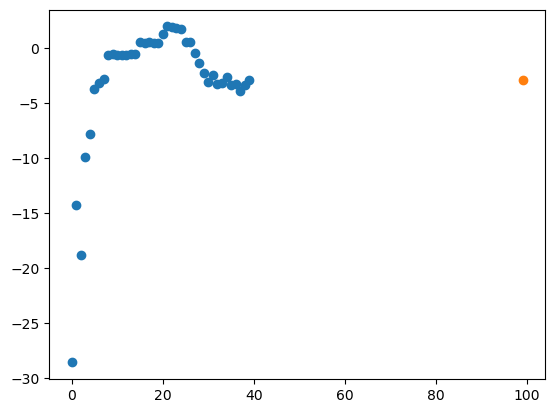

In [87]:
#note: any plots that include less than 100 data points is due to regression returning nan 
#note: I have not implemented anything yet on dealing with nan, eg resubmitting the calculation
#note: the single dot at the end is just for validation of my running average

#for outcome in outcomes: #plot for all outcomes
for outcome in [outcomes[0]]:   #set a specific outcome
    #for duration in durations: #plot for all durations
    for duration in [durations[0]]: 
        #for sampleSize in sampleSizes: #plot for all sample sizes
        for sampleSize in [sampleSizes[0]]:
            #for iCvRisk in range(len(cvRisks)): #plot for all cv risks
            for iCvRisk in [0]: #set a specific risk, 0-4            
                #for iDementiaRisk in range(len(dementiaRisks)): #plot for all dementia risks
                for iDementiaRisk in [0]: #set a specific dementia risk, 0-4
                    plotData=results.loc[ #get all relevant data
                    (results["outcome"]==outcome) & 
                    (results["sampleSize"]==sampleSize) &
                    (results["dementiaRisk"]==dementiaRisks[iDementiaRisk]) & 
                    (results["cvRisk"]==cvRisks[iCvRisk]) &
                    (results["duration"]==duration), "runMeanReg"].copy()
                    plt.scatter(range(len(plotData)),plotData)
                    plt.scatter(99,meanReg[f"{outcome},{duration},{sampleSize}"][iCvRisk,iDementiaRisk])


death,3,100


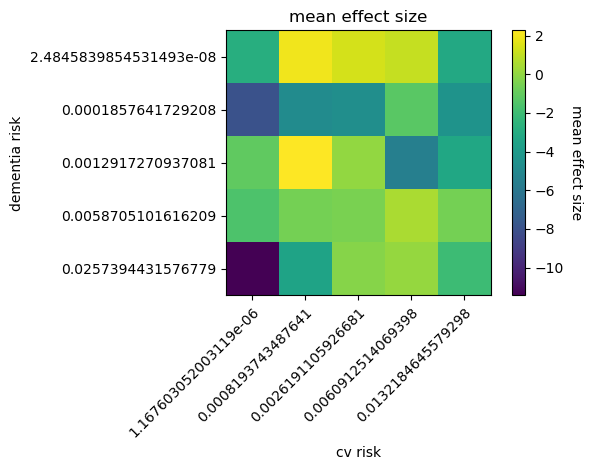

death,3,100


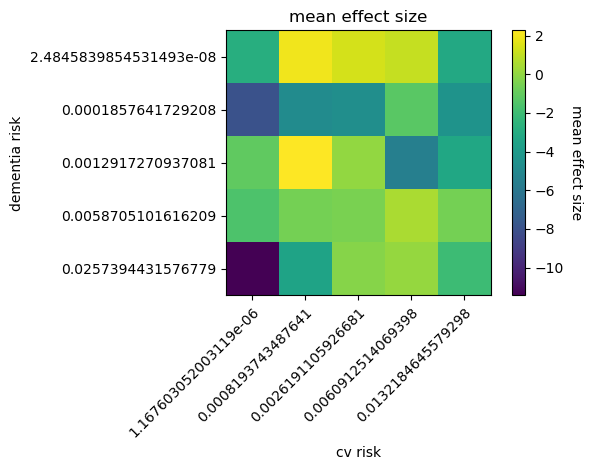

death,3,100


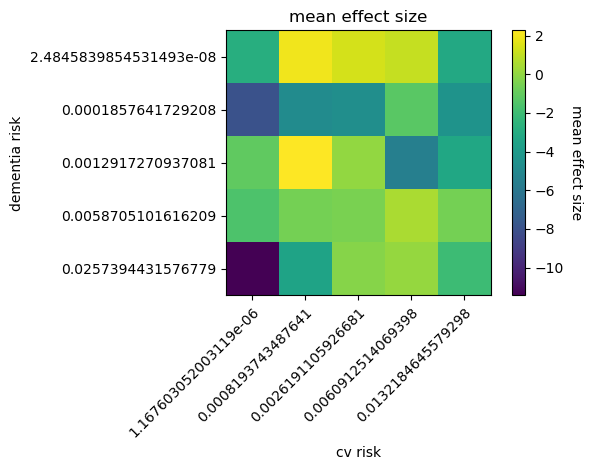

death,3,100


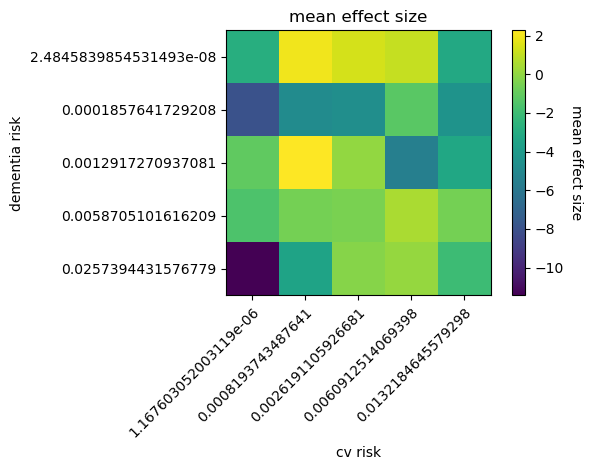

death,3,100


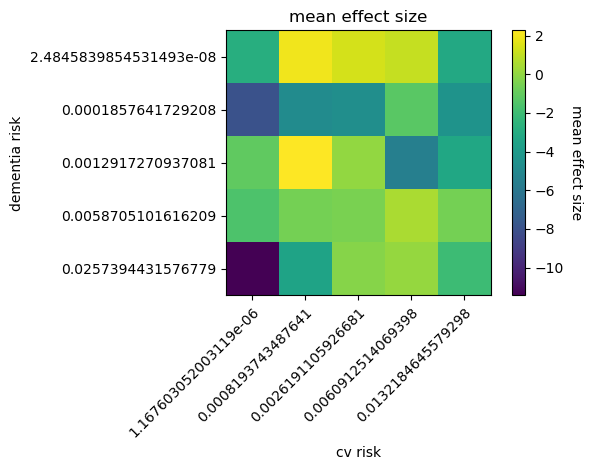

In [88]:
for outcome in [outcomes[0]]:    #change to outcomes in order to see all heatmaps associated with all outcomes
    for duration in durations:
        for sampleSize in [sampleSizes[0]]:  #change to sampleSizes to see heatmaps associated with all sample sizes
            print(f"{outcomes[0]},{durations[0]},{sampleSizes[0]}")
            dataForPlot=meanReg[f"{outcomes[0]},{durations[0]},{sampleSizes[0]}"]
            fig, ax = plt.subplots()
            im = ax.imshow(dataForPlot)

            # Show all ticks and label them with the respective list entries
            ax.set_xticks(np.arange(len(cvRisks)), labels=cvRisks)
            ax.set_yticks(np.arange(len(dementiaRisks)), labels=dementiaRisks)
            ax.set(xlabel='cv risk', ylabel='dementia risk')

            # Rotate the tick labels and set their alignment.
            plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
            rotation_mode="anchor")

            cbar = ax.figure.colorbar(im, ax=ax)
            cbar.ax.set_ylabel("mean effect size", rotation=-90, va="bottom")

            ax.set_title("mean effect size")
            fig.tight_layout()
            plt.show()